[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drscotthawley/DLAIE/blob/main/Lessons/04_ProblematicImageAnalyzer.ipynb)

*Note: GitHub.com does not render everything when viewing these notbeook files, so click the "Open in Colab" button above to see everything as it's intended.*

# Let's Make an (Ethically Problematic) Image-Analyzer!
*by Scott H. Hawley, August 29, 2021, updated Sept 12, 2023*  

---

This coding lesson was inspired by two papers:

* ["Integrating Ethics into Introductory Programming Classes"](https://dl.acm.org/doi/10.1145/3408877.3432510) by Casey Fiesler et al, SIGCSE '21: Proceedings of the 52nd ACM Technical Symposium on Computer Science Education, March 2021.
* ["Mitigating dataset harms requires stewardship:
Lessons from 1000 papers"](https://arxiv.org/abs/2108.02922) by Kenny Peng, Arunesh Mathur, Arvind Narayanan, arXiv:2108.02922, cs.LG, August 2021.

---

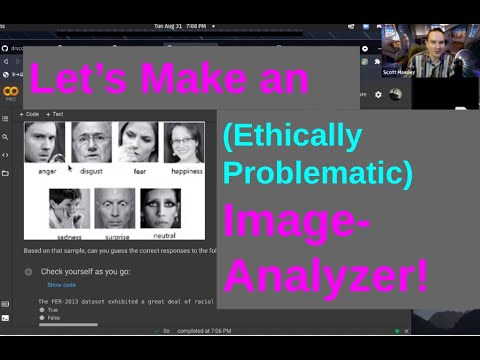

In [ ]:
#@title This video goes with this notebook:
from IPython.display import YouTubeVideo
YouTubeVideo('Wl1NOUHZL08') # https://youtu.be/Wl1NOUHZL08

Computer vision problems often serve as onramps for learning about deep learning (DL), maybe because it's an area where DL's successes have been so demonstrable, and/or also because many of us are "visual learners." So, there are a few types of apps that we can try to make with images, and I wrote the title as "analyzer" as a deliberately vague ploy to skirt the boundary between two main applications:

classification: what kind of thing is this a picture of?
facial recognition: which particular person is this a picture of?
Classification is usually covered first, so we'll do that.

In [1]:
# First, let's install a few things
%pip install -Uqq fastai duckduckgo_search git+https://github.com/drscotthawley/mrspuff.git
%pip install -q bokeh==2.4.3  # downgrade bokeh for now

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 43.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 1.2.2 requires bokeh<3.3.0,>=3.1.1, but you have bokeh 2.4.3 which is incompatible.


In [2]:
# and import what we'll eventually need
from fastai.vision.all import *
from fastcore.basics import *
from fastai.vision.widgets import *
import mrspuff
import mrspuff.quiz as quiz
from IPython.display import HTML, display
from duckduckgo_search import ddg_images

In [3]:
# And just as a check: what kind of GPU do we have? (Probably a Tesla T4.)
!nvidia-smi

Wed Sep 13 12:24:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## What shall we build?
What kind of "app" do we want to make?  It's common to do something cute like distinguishing between kinds of animals (dogs and cats, [pet breeds](https://www.robots.ox.ac.uk/~vgg/data/pets/), [types of bears](https://colab.research.google.com/github/fastai/fastbook/blob/master/02_production.ipynb),...) but since this course is on "Deep Learning *and AI Ethics*" we're going to follow [Casey Fiesler et al](https://dl.acm.org/doi/10.1145/3408877.3432510) and choose something ethically challenging, which means we use images of **people**!

How about a system that makes all kinds of inferences about people based on [your face](https://www.ft.com/content/cf19b956-60a2-11e9-b285-3acd5d43599e)?  That would be ethically-challenged, right?  And such systems have been used to predict [criminality](https://www.wired.com/story/algorithm-predicts-criminality-based-face-sparks-furor/), [sexual orientation](https://www.theguardian.com/technology/2017/sep/07/new-artificial-intelligence-can-tell-whether-youre-gay-or-straight-from-a-photograph),... it's really the limit of your imagination:

* How about an app that predicts your child's future earnings based on a photograph, or maybe some other data? [Oh wait. That doesn't work.](https://www.technologyreview.com/2020/04/02/998478/ai-machine-learning-social-outcome-prediction-study/)
* How about an app that decides how hireable you are based on a photo?  [Been there, done that.](https://www.washingtonpost.com/technology/2019/10/22/ai-hiring-face-scanning-algorithm-increasingly-decides-whether-you-deserve-job/)  But that gives me an idea...


## App Idea: Are You Being a Good Student?

*(H/T: The initial idea for this app was suggested by algorithmic bias specialist [Vienna Thompkins](https://twitter.com/vienna_valencia).)*

When I visited the [AI in Education (AIED)](https://iaied.org/) conference a few years ago, the most advanced systems I observed were (consistently) from various researchers in China who were using deep learning to track student behavior, i.e. to perform *automated surveillance for education*, whether via analysis of video cameras pointed at the class, or videos from -- and this is relevant for us -- *online education*!

As an indicator of the interest in this field, here's a smattering of some articles on automated surveillance applications in education:
* ["Engagement detection in online learning: a review"](https://slejournal.springeropen.com/articles/10.1186/s40561-018-0080-z)
* [Monitoring Students’ Attention in a Classroom Through Computer Vision](https://www.researchgate.net/publication/325850031_Monitoring_Students'_Attention_in_a_Classroom_Through_Computer_Vision)
* [Developing a Machine Learning Algorithm to Assess
Attention Levels in ADHD Students in a Virtual
Learning Setting using Audio and Video Processing](https://www.ijrte.org/wp-content/uploads/papers/v10i1/A59650510121.pdf)
* [A Computer-Vision Based Application for Student
Behavior Monitoring in Classroom](https://www.mdpi.com/2076-3417/9/22/4729/pdf)
* [Emotion Recognition of Students Based on Facial Expressions in Online Education Based on the Perspective of Computer Simulation](https://www.hindawi.com/journals/complexity/2020/4065207/)
* [Student Engagement Detection Using Emotion Analysis, Eye Tracking and
Head Movement with Machine Learning](https://arxiv.org/pdf/1909.12913.pdf)



...And up until summer 2021, there were multiple Chinese companies offering individualized (spoken) English language tutoring to students in China by connecting them with American instructors via video conferencing. (Like Zoom, but not Zoom.)

Recordings and/or live-streams of these sessions would be routinely scanned by human monitors in China as well as by automated systems to check for violations of Chinese policy (e.g. showing a map where Taiwan was not included as part of China) and for any evidence of students or teachers not exhibiting exemplary behavior.

One thing American instructors found to be a bit odd was that students typically announced very clearly at the start of each session, "I am happy!"  Because happy is good. Happy people are good citizens. Happy students are good students.  *(Source: Personal comments from an instructor I know who'd like to keep his/her job)*



In [4]:
#@title Question to check yourself:  (press the "Play" button to the left first)
# this is totally sarcastic and hopefully everyone will understand that, and not be too confused ;-)
quiz.mc_widget('Are good students always happy?',['Yes','No'],'Yes')

....Good. ;-)  Now you get the idea of the sort of app we're going to make! ;-)

 This is from the same country that brought you an ML app that predicts [whether you're likely to be a criminal based on a photo](https://www.rt.com/news/368307-facial-recognition-criminal-china/) -- ok wait, that was from China in 2016, but [here's the same idea from the USA in 2020](https://www.wired.com/story/algorithm-predicts-criminality-based-face-sparks-furor/)!

We could perhaps pattern our system after this one:

* ["Design of Intelligent classroom facial recognition based on Deep Learning"](https://www.researchgate.net/publication/331681396_Design_of_Intelligent_classroom_facial_recognition_based_on_Deep_Learning) by Jielong Tang, Xiaotian Zhou, and Jiawei Zheng, *Journal of Physics Conference Series* 1168(2):022043, Feb 2019.

...Except that they used the [FER-2013](https://www.kaggle.com/msambare/fer2013) dataset, which,...well, here's a representative sample:

![fer2013 example](https://d3i71xaburhd42.cloudfront.net/9227c1a5b26556b9c34015b3ea5f9ae5f50e9b23/3-Figure5-1.png)


Based on that sample, can you guess the correct responses to the following True/False statements?


In [5]:
#@title Check yourself as you go:
display(quiz.mc_widget('The FER-2013 dataset exhibited a great deal of racial diversity.',['True','False'],'False'))
display(quiz.mc_widget('FER-2013 contained lots of pictures of actual students in either classrooms or online learning environments.',['True','False'],'False'))

Furthermore, one might ask, is it even reasonable to expect AI (or humans for that matter) to detect emotions just from photographs?

No it's not: ["YOU CAN’T DETERMINE EMOTION FROM SOMEONE’S FACIAL MOVEMENTS–AND NEITHER CAN AI"](https://news.northeastern.edu/2021/08/20/you-cant-determine-emotion-from-someones-facial-expression-and-neither-can-ai/) (Northeastern U., Aug. 20, 2021).

...But that won't deter people from making apps that purport to do it, [possibly violating laws](https://www.jdsupra.com/legalnews/employers-using-ai-in-hiring-take-note-54767/) in the process,  so we're going to do it!  ...And we'll inspect how such a (problematic) system might operate -- or even how it might completely fail to even deliver on its problematic promises. (Heck, as long as we can sell it to somebody, who cares, right? ;-)  <-- The winky face means I'm being sarcastic, embodying an ethically-uninformed position one might find in various sectors of industry or even academia.)

So, what should we use for a training dataset?

## How/Where to Get Training Data?
The nice thing about FER-2013 is that it *already exists*.  Many a ML project follows the path of, after the initial idea, looking around for "What existing datasets can we grab?" [even if those existing datasets have underlying ethical issues](https://exposing.ai/datasets/).  In other words, we *could* just use somebody else's dataset that we find "out there" and...just not worry about or ask [how it was created](https://yalebooks.yale.edu/book/9780300209570/atlas-ai) -- because that's like asking the AI version of "how the sausage gets made", yuck! ;-)

How was FER-2013 created?  From the [original paper](https://arxiv.org/pdf/1307.0414v1.pdf):

> FER-2013 was created by Pierre Luc Carrier and Aaron Courville. It is part of a larger ongoing project. The dataset
was created using the Google image search API to search for images of faces
that match a set of 184 emotion-related keywords like “blissful”, “enraged,” etc.
These keywords were combined with words related to gender, age or ethnicity,...

Ok, so, they scraped the internet. We can scrape the internet too (spoiler: That is in fact what we'll do), but let's talk about this some more. Scraping the public itnernet is not too problematic.  Scraping sites where people login and post personal information, e.g.  [scraping dating sites](https://www.newyorker.com/news/daily-comment/the-ai-gaydar-study-and-the-real-dangers-of-big-data)
is a lot more problematic.  

Instead of scraping, we could do what researchers at Duke University did, setting up [surveillance cameras all over campus](https://www.dukechronicle.com/article/2019/06/duke-university-facial-recognition-data-set-study-surveillance-video-students-china-uyghur) and not telling anybody -- oh wait, they had to retract all that and apologize...

> ...*even though* most universities have a clause that all students sign saying the university can use your photo for anything, anytime...

...let's just not.  Here are a few more questions we might want to think about for the ethical construction of our dataset:

* **If we're academics,** then we might want to share a version of our dataset so other people can verify our results. This brings up questions:
    * Do we have the license to re-distribute the images?  (The maintainers of [CelebA](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) confess they *do not*.)
    * If we modify some existing dataset, do we have a licence to redistribute a *modified form* of that dataset?  

* **If we're at a company,** we might not want to release our training dataset.  In that case, where we get our data from doesn't matter, right? Even if the training dataset we grab is designated as being for non-commerical use only, who would ever know, right? Hold up:
    * Turns out that [it's possible to extract training data from a trained model](https://arxiv.org/pdf/1709.07886.pdf).

...Darn, all this ethics stuff can be INCONVENIENT -- it's [stifling innovation](https://www.business-of-data.com/articles/ai-ethics-debate-2020/)!

For us, we're going to exercise the usual "education loophole". What we're going to do today is for non-commerical, education & research use.  We're going to scrape some images from the public internet, we're not to redistribute them....and the result is going to be a very poorly-performing model!!!


## Datasets are a big deal, it turns out
Often machine learning pedagogy starts with "we're just going to grab XXXX dataset in order to illustrate this model/concept."  And it's innocuous as [flowers](https://towardsdatascience.com/the-iris-dataset-a-little-bit-of-history-and-biology-fb4812f5a7b5). But in real life, you have to make your own dataset, and you have to "clean" your own dataset, and you have to make sure you aren't violating ethical principles or licensing concerns. Getting training data is the less-talked-about "underside" of machine learning and especially deep learning.  But it's [starting to receive more attention](https://www.forbes.com/sites/gilpress/2021/06/16/andrew-ng-launches-a-campaign-for-data-centric-ai/).


> And by the way, we haven't even talked about [how problematic the labels can be](https://excavating.ai/) for supervised classification projects, even for some of the most carefully curated datasets.


...I think you're starting to get the idea that **even the act of creating some kind of facial-recognition app is fraught from the get-go**, just over the issue of the dataset itself.  It's possible that these ethical issues may cause you to even [abandon the field of computer vision research](https://twitter.com/pjreddie/status/1230524770350817280).

But hey, some ethically-challenged person's going to do it, and you don't want to give the [Chinese an edge](https://www.scientificamerican.com/article/will-china-overtake-the-u-s-in-artificial-intelligence-research/) in AI development, do you?  

## 2023: Scraping Data from the Internet is No Longer a Given

It used to be that "scraping the internet" for data -- usually text and/or images -- was a common practice, accepted by ML researchers & and companies.

Today, if you do a web search on "[ethics of data scraping 2023](https://www.startpage.com/do/search?q=ethics+of+data+scraping+2023)" you will see numerous articles discussing changes in public attitudes about this, and legal cases involving data scraping.

Usually, scraping for research or educational purposes was (and still is) largely uncontested.

The problems usually arise in regards to using the data to build commercial products.

This is such an important, changing topic, that we will devote further attention to later in the course. For now, we're going to move on to just *doing it anyway*  (we said this would be ethically problematic, right?), and revisit the topic of the ethics and legality of using scraped data at a later date.




## Make Your Own Dataset

> <i>"Anyone working in ML, anyone, should be obliged to curate a dataset before they're allowed to train a single model. The lessons learnt in the process are invaluable, and the dangers of skipping said lessons are manifold (see what I did there?)"</i><br>
> --<i>[Justin Salamon](https://twitter.com/justin_salamon/status/1202016519720300545), Senior research scientist at Adobe Research. (Machine learning and signal processing for audio & video.)</i>

We're going to scrape DuckDuckGo for images of three categories of students:

* good student
* bad student
* bored student

> Note: We will be performing *supervised learning* by letting the search engine supply the ground-truth *labels* for our deep learning model.

These will then feed into our social credit system (beyond the scope of this course):  bad students will be penalized, and "bored student" will mean the *teacher* will be penalized! Let's see how (toally awful) this design plays out:

Now let's tell it to scrape...

In [6]:
dl_path = 'scraped_images'  # the folder where we're saving to
labels = 'good','bad','bored'
search_suffix = 'student'
path = mrspuff.scrape.scrape_for_me(dl_path, labels, search_suffix, max_n=200)

/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


good student: Got 90 image URLs. Downloading images...
   urls =  ['https://www.hiboox.com/wp-content/uploads/2020/02/student-1.jpg', 'https://lindastade.com/wp-content/uploads/2019/03/shutterstock_102482084-e1552480105382.jpg', 'https://www.schoolsofdehradun.com/wp-content/uploads/2019/08/QUALITIES-OF-A-GOOD-STUDENT.jpg', 'https://www.pitmanroaringtimes.com/wp-content/uploads/2018/11/100602603.jpg', 'https://i1.wp.com/rollercoasteryears.com/wp-content/uploads/Thrive-During-Finals-.jpg?fit=1000,667&ssl=1', 'https://yourteenmag.com/wp-content/uploads/2013/06/Depositphotos_24196475_l-2015.jpg', 'https://stemeducationguide.com/wp-content/uploads/2021/05/What-Makes-A-Good-Student.jpg', 'https://images.saymedia-content.com/.image/t_share/MTc2MjY5ODExMDQ1NjM5MzQx/to-be-an-ideal-student.jpg', 'https://www.ucg.org/files/styles/full_grid9/public/image/article/2011/07/15/five-qualities-of-successful-students.jpg', 'https://img.freepik.com/free-photo/good-student-posing-with-notebook-backpack_23-

We're going to use FastAI for our Deep Learning model's training loop.  There are a few ways to specify data in FastAI and to create "DataLoaders" (abbreviated in code as "dls).

Let's set up a data loader for our images of "good [student]", "bad [student]", and "bored [student]" --- knowing full well that these are going to be really problematic and maybe even unusable.  (How could anybody hope to capture the idea of "good student" in a single image??  But we're doing it anyway, because someone else will be making such an app.) In fact, let's take a look at some sample images:

*(Don't worry about the specifics of the following code block for now, we'll come back later in the course and talk about it.)*  

## Load the dataset

In [7]:
# Don't worry about the specifics of this code just yet. We'll talk about it later in the course.
# In this lesson, we're essentially going to be following "Chapter 2: Production" from the FastAI book:
#   https://github.com/fastai/fastbook/blob/master/02_production.ipynb

def setup_dls(
    path    # string specifying top level of directory/folder tree where images are stored.
    ):
    "Setup FastAI DataLoaders"
    data = DataBlock(        # define fastai data structure
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label,
        item_tfms=RandomResizedCrop(224, min_scale=0.5),
        batch_tfms=aug_transforms())
    dls = data.dataloaders(path)    # define dataloader(s)
    return dls

dls = setup_dls(path)

Let's take a look at some of the images:

Types of Students (good, bad, bored):


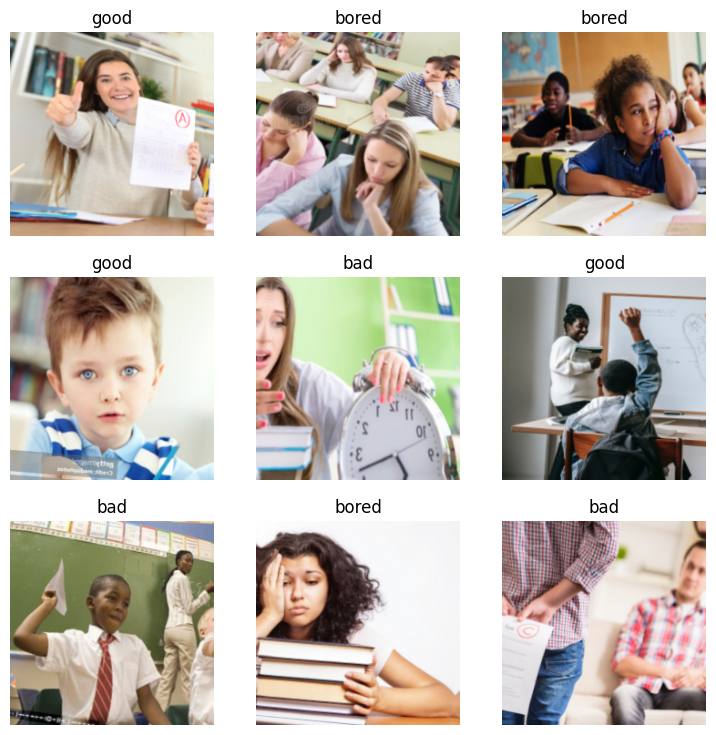

In [8]:
print("Types of Students (good, bad, bored):")
dls.show_batch()

> ...And remember, bored students mean we fire the *teacher*!  You're not bored are you? Don't answer.

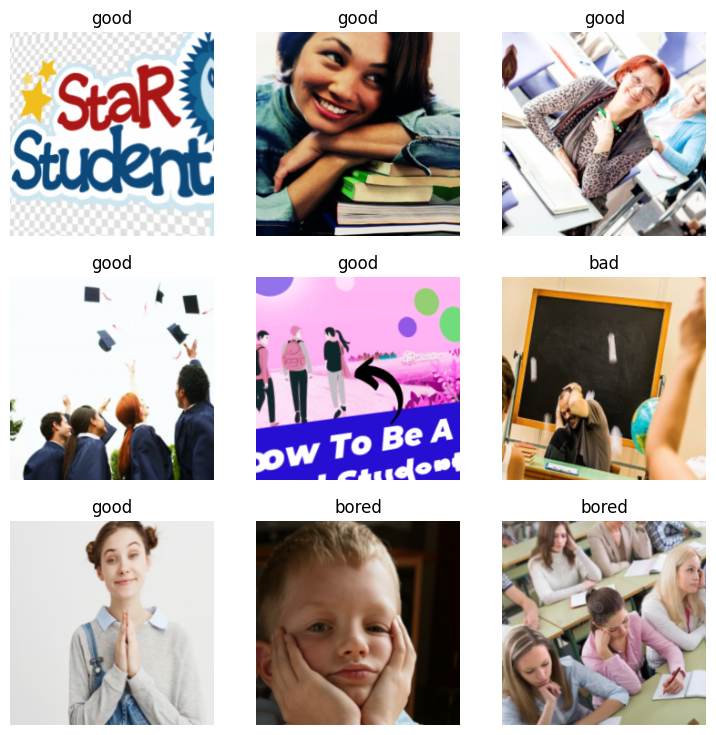

In [9]:
# Note: you can run show_batch() over & over, & it will grab a different set each time:
dls.show_batch()
# yikes,looks we got cartoon images mixed in. hmmmm

...Ok, so you're probably noticing that *scraping from the internet doesn't guarantee quality data*, right?  Some of the images don't even show human beings.  Depending on when you ran the scraping code, you might see cartoons, or...lots of things.

> You're probably also noticing that **maybe the task we're trying to perform isn't really even a meaningful one**, but that will not dissuade us in our ethically-challenged app development!

## Clean the Data -- First?
We're  going to want to "clean" the data. But rather than cleaning the data immediately, "from scratch", we actually will ([as the FastAI authors recommend](https://render.githubusercontent.com/view/ipynb?color_mode=auto&commit=780b76bef3127ce5b64f8230fce60e915a7e0735&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6661737461692f66617374626f6f6b2f373830623736626566333132376365356236346638323330666365363065393135613765303733352f30325f70726f64756374696f6e2e6970796e62&nwo=fastai%2Ffastbook&path=02_production.ipynb&repository_id=243838973&repository_type=Repository#Training-Your-Model,-and-Using-It-to-Clean-Your-Data)) *train our model first anyway*, and then *use the model* to help us go back and sift through which images are causing problems.

## Terminology Interlude

What we did above was actually create *two* datasets, which are subsets of our total datasets.  One subset is called the *Training* dataset (which FastAI abbreviates as `Train`) and this is the one that the neural network uses for training.  The other subset is called the *Validation* set (which FastAI abbreviates as `Valid`) and is "held out" and used to *monitor* how well the model is "generalizing" for data it's never seen before.

* **Training set:** Subset of total data, usually approximately 80% of the total dataset.  This is the only part the model "trains" on.
* **Validation set:** Held-out subset, usually approximaately 20% of total data. Used for monitoring, i.e. for metrics such as accuracy & error rate (defined below). Useful to providing some indication of how well the model generalizes.
* **Accuracy**: The percentage of correct predictions (using only the Validation set) made by the model.
* **Error rate**: Same information as the Accuracy, just 100%-Accuracy.
* **Loss**: A function that measures "how far off" we are in our predictions compared to the "correct" answer (i.e. the labels). Training consists in trying to lower the loss by a series of tiny adjustments to the model. Unlike Accuracy, Loss needs to be a continuous function of the mdoel & the inputs. Training loss (i.e. loss on the Training set) is pretty much guaranteed to always decrease, whereas the true measure of how well the training is going is whether the Valid
* [Link to course Glossary](https://github.com/drscotthawley/DLAIE/blob/main/Glossary.md).

There are nice graphical ways to envision Accuracy & Loss, which we'll look at after we try training (below).


## Train the Model

We're going to use FastAI to train our model with just a couple lines of code, also using my ["triangle diagram" visualization](https://drscotthawley.github.io/blog/scottergories/2021/05/04/The-Joy-Of-3D.html) from `mrspuff.viz` so that we can track the progress of the model's training.

In the following, if you mouse-over the "dots" you'll see a thumbnail of images from the Validation set.
The color shows the how the image was labeled (blue="good", red="bad", green="bored") whereas the region of the diagram it appears in indicates what the model predicts for that image.



*Note: if you get prompted to "Connect your Google Drive," say yes.*

In [10]:
learn = cnn_learner(dls, resnet34, metrics=[accuracy, error_rate])
learn.fine_tune(6, cbs=mrspuff.viz.VizPreds)  # fine_tune does 1 epoch 'frozen', then as many more epochs you specify

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593

Generating (URLS of) thumbnail images...
Mounted at /gdrive
Thumbnails saved to Google Drive in /gdrive/My Drive/scraped_images_thumbs/
Waiting on Google Drive until URLs are ready.



Epoch 0: Plotting 48 (= 48?) points:


Epoch 0: Plotting 48 (= 48?) points:


Epoch 1: Plotting 48 (= 48?) points:


Epoch 2: Plotting 48 (= 48?) points:


Epoch 3: Plotting 48 (= 48?) points:


Epoch 4: Plotting 48 (= 48?) points:


Epoch 5: Plotting 48 (= 48?) points:


...Ok, so it starts off a complete jumble, and then...gets a bit better. Note that the "dots" you see above are *only* from the Validation set, so that we can really see how well the model is "learning". If we showed the Training set, there's a chance that the model could "cheat" by "memorizing" the training points, a process often described by the term "overfitting".

> Hey: if you'd like to see a "cleaner" example of this using animals instead of people, see [my blog post from June 2021](https://drscotthawley.github.io/blog/posts/2021-06-17-contrasting-contrastive-loss.html).


Now that you've seen these diagrams, lets use them as examples for visualizing Accuracy, and its relation to loss.  Accuracy is how many of the dots end up the region matching their label, i.e. on the correct side of the dividing line:

![100% accuracy pic](https://raw.githubusercontent.com/drscotthawley/DLAIE/main/images/accuracy_100.png)

So that was 100% accuracy, but if the predicted points were *juuuust* barely on the other side of the decision boundaries, the Loss would be nearly the same as before (because loss is a measure of "distance" from the intended label) but the accuracy would drop to 0:
![0% accuracy pic](https://raw.githubusercontent.com/drscotthawley/DLAIE/main/images/accuracy_0.png)





Here's a different way to look at how many predictions the model gets "right" (according our labels from the search engine) or wrong, called a "Confusion Matrix", which displays the same information as above but in tabular form:

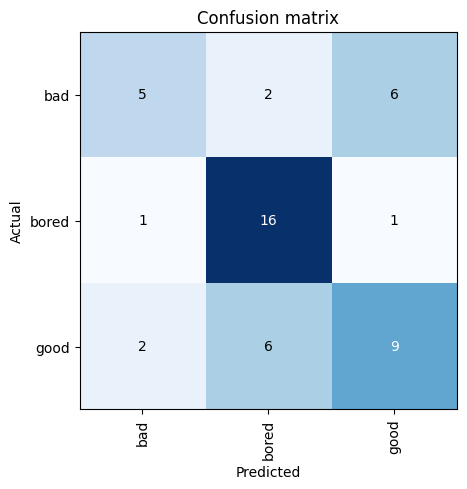

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Where again, this is only for the Validation data, since the Training data is already "learned" by the model.

Lets take a look some of the images that produce the "top losses"; these will be the ones most "distant" from their intended triangle-vertex in the triangle diagram:

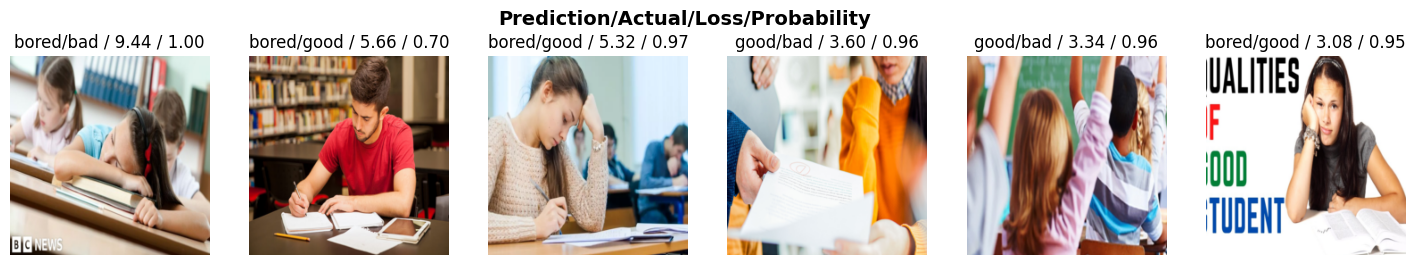

In [12]:
interp.plot_top_losses(6, nrows=1)

## Clean the dataset
How can we improve the dataset? Perhaps there are images that you think are mislabeled, or should be deleted entirely.  For example, if we eventually want to hook this up to a webcam, how useful are *cartoons* going to be?  For that matter, how useful are images of multiple students in a classroom going to be?  (Probably not very.)

FastAI has a "widget" utility to go through and edit the labels for either the Train[ing] or Valid[ation] datasets.  Go through it and delete all the cartoons and any other images you think don't belong:

In [13]:
# Note it doesn't always show the whole dataset, so you might re-run this a few times
cleaner = ImageClassifierCleaner(learn, max_n=60)
cleaner

...What you do above doesn't actually take effect until you run the following snippet of code:

In [14]:
# this code actually executes your cleaning operations

for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

# What that did was actually unlink/delete files "on the disk".
# So after that, we need to re-load the data:
dls = setup_dls(path)       # load new dls from disk...uh...note that this remixes Train/Valid though :-/
learn.dls = dls             # replace the learner's dls with the newly-loaded one

# How many files are left now?
!ls -1 scraped_images/* | wc -l

# Now you can go back up and re-run the Cleaner to take another look

249


Spend some time cleaning the dataset, iterating the previous two code cells. Don't forget to work on both Train **and Valid[ation]** sets!

## Retrain, rinse, repeat
So with notebooks like Colab, it'd be easiest to just scroll up and re-run the training loop using this new dls.  But for comparison's sake, I'll re-type the training code below...

In [15]:
learn = cnn_learner(dls, resnet34, metrics=[accuracy, error_rate]) # reset the learner
learn.fine_tune(6, cbs=mrspuff.viz.VizPreds)

Generating (URLS of) thumbnail images...
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
Thumbnails saved to Google Drive in /gdrive/My Drive/scraped_images_thumbs/
Waiting on Google Drive until URLs are ready.



Epoch 0: Plotting 48 (= 48?) points:


Epoch 0: Plotting 48 (= 48?) points:


Epoch 1: Plotting 48 (= 48?) points:


Epoch 2: Plotting 48 (= 48?) points:


Epoch 3: Plotting 48 (= 48?) points:


Epoch 4: Plotting 48 (= 48?) points:


Epoch 5: Plotting 48 (= 48?) points:


Keep cleaning the dataset and see if you can get the accuracy up to at least..oh...let's shoot for 75%.  Surely some school system would buy our product if it's at least 75% accurate, right? ;-)  THIS WILL PROBABLY TAKE YOU AN HOUR of data-cleaning. Cleaning is what Data Scientists and Data Engineers spend *a lot* of time doing.

> And the important point is, people may use something like this for hiring decisions, or governments for guessing who's a terrorist, or your local convenience store to predict whether you look like the sort of person who's likely to shoplift and if should we notify security to follow you around... You name it.

> Students: Stop here for now. Still working on what follows.

---

# Part 2: Salience: What's the model looking at?
What are the features of the images that are leading to different classification "conclusions"?  Maybe things like smiling for "good", or a hand touching the head for "bored"?   We can send in an image and then look at the internal activations of the model with respect to the 3 different class outcomes.

> One package I *love* for salience is Misa Ogura's [flashtorch](https://github.com/MisaOgura/flashtorch), but it relies on an old version of PyTorch so it won't work for us.  If you want to see her code in action for a different model, see [her Medium post](https://towardsdatascience.com/feature-visualisation-in-pytorch-saliency-maps-a3f99d08f78a) and/or [her Colab example](https://colab.research.google.com/github/MisaOgura/flashtorch/blob/master/examples/visualize_saliency_with_backprop_colab.ipynb) for cool stuff.  But sadly, we must try other methods until `flashtorch` is updated.  So, moving on...

We'll try a method known as "GradCAM", which draws a blob around the area of an image that is most "salient" or "influential" in reaching a certain prediction-outcome.

In [16]:
!pip install pytorch-gradcam

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp
from torchvision.utils import make_grid, save_image
from torchvision import transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 16.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5247 sha256=6376682e2970e5decd7de13c1616d8cc1608ebaf94677874ed723a7aa9cf4b1a
  Stored in directory: /root/.cache/pip/wheels/6f/f1/8f/96c81d13f617841f23cae192a77fea3e9e988d058ba9414f2c
Successfully built pytorch-gradcam


Let's grab an image for "bored":

scraped_images/bored/bored-student-picture-id184941500_weoYUwRrHn.jpg


('bored', tensor(1), tensor([0.1977, 0.7994, 0.0028]))

So the label for this image is "bored", but the model predicts "bored".


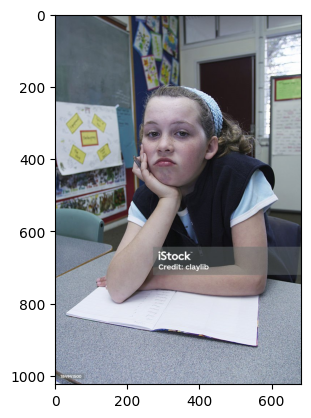

In [17]:
# dls.valid.items are the filenames in the Validation set, and they contain the directory/label names
label, file_num = 'bored', 5
img_path = [s for s in dls.valid.items if label in str(s)][file_num] # grab a filename
print(img_path)
image = load_image(img_path)
plt.imshow(image)
pred = learn.predict(img_path)
print(pred)
print(f'\nSo the label for this image is "{label}", but the model predicts "{pred[0]}".')

Why did the model reach that conclusion? What part of the image was salient to the model?  Let's generate a GradCAM map and take a look:

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


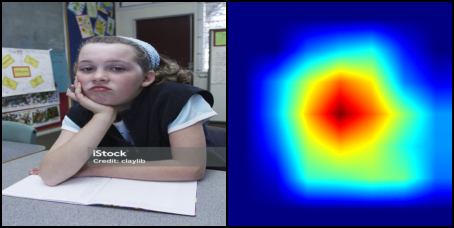

In [18]:
dl = learn.dls.test_dl([img_path])
x = first(dl)
torch_img = detuplify(dl.decode_batch(x)[0])
x = detuplify(x)
normed_torch_img = x

target_layer = learn.model[0]
gradcam = GradCAM(learn.model, target_layer)

mask, _ = gradcam(normed_torch_img)
heatmap, overlay = visualize_cam(mask, torch_img)
images = [-torch_img.cpu(), heatmap]
grid_image = make_grid(images)
transforms.ToPILImage()(grid_image)

> *Aside: Thanks to [Benjamin Warner](https://benjaminwarner.dev/) and [Tanishq Abraham/@ilovescience](https://twitter.com/iScienceLuvr) on the FastAI Discord for help getting this GradCAM example working!*


...So the red area is supposed to be the imporant part for influencing the prediction.

Let's try a different salience method called "Integrated gradients", using a package called [Captum](https://captum.ai/):

In [19]:
!pip install -Uq git+https://github.com/pytorch/captum.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


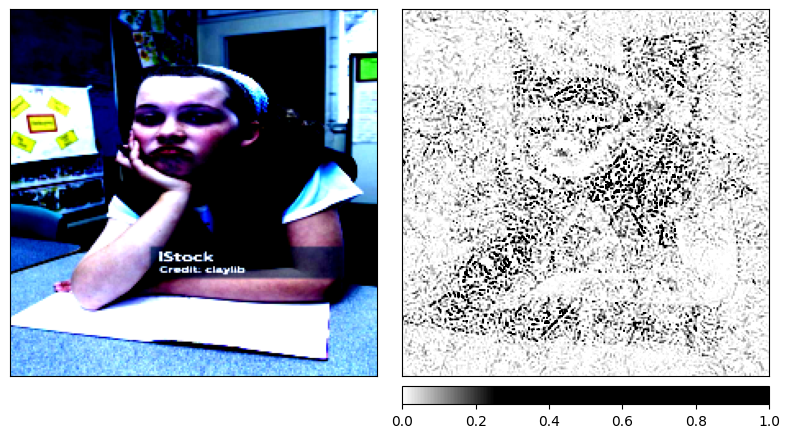

In [20]:
#@title Hiding Integrated Gradient code details here, just press the run button ;-)
from captum.attr import IntegratedGradients, NoiseTunnel
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

model = learn.model.eval()
pred_label_idx = 2
transformed_img = normed_torch_img
input = normed_torch_img

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

Ok...that's not very helpful.  Let's try to smooth it out a bit by adding some noise to the input.  

.

If this next cell produces an "CUDA out of memory" error, then just nevermind for now:

In [22]:
#@title Hiding Captum "noise tunnel" code. Just press play...
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

OutOfMemoryError: ignored

The hope with the salience mapping is that it should point out the parts of the image that were most important for a given classification outcome, but this isn't very helpful, is it?  ....If I can get `flashtorch` working, we'll come back and revisit this.

## Discussion
This was a horrible, awful idea from the very beginning. We'll talk about this in class.  For now, please consider a few additional questions:

* Say you're a goverment contractor (e.g. Palantir) who wanted to develop a system to automatically predict (i.e. decide) whether someone is a terrorist or not?   (Such automated systems are a part of Homeland Security checkpoints BTW. TODO: citation...)
    * How would you go about getting a dataset of terrorists and non-terrorists?
    * What might be some problems with collecting that data at all?
    * How would you obtain the photos of terrorists taken *before* they commit crimes?
    * What might be some problems with the "representation" in the dataset? (e.g. upstanding White non-terrorists vs. Muslim men with beards or women wearing burkhas)
    * What sort of "false positive rate" (i.e. how often it says "terrorist" when the person's not one) is tolarable?   What sort of "false negative" (letting terrorists slip through undetected) rate is acceptable?  
        * Which side would you prefer to "err" on: public safety or personal liberty?
    * What if the false positive rate is different for one demographic than another?
    * What might be the negative *and positive* consequences of deploying your system all over the world, and not just in airports but schools, shopping malls, etc.?  (e.g. Chinese citizens often report the public safety benefit of widespread automated surveillance as a net positive.)
    * What else comes to mind...?
    

## Deploying our model?
What about releasing our model as an app, e.g. on [Gradio](https://gradio.app/)?  Tell you what, let's wait until we develop a model that's not so fraught with ethical and performance issues.  We'll come back to the topic of deploying models later.

## Exercise: Your own problem
Go back up to the top and scrape three categories of your own interest, and re-run all the cells that follow.  (We could more or fewer than 3, but the "triangle plot" viz works well for 3 classes.  BUT IT WILL WORK FOR 4!  If you want, give it 4 classes and watch what happens.)  

The `suffix` label we used could be made blank if you don't want it. Sometimes it helps.  Here are a couple examples that come to mind:

* Professions: `labels = 'doctor', 'nurse', 'ceo'`, `suffix=''`  (Notice any gender biases?)
* Guitars: `labels = 'stratocaster', 'les paul', 'acoustic`, `suffix='guitar'`  (See former Belmont student Nathan Sepulveda's guitar classifier app in action: https://twitter.com/nateysepy/status/1374888237169262597)
* Cats: `labels = 'tabby', 'maine coon', 'persian'`, `suffix='cat'`
* Cars: `labels = 'delorian', 'corvette', 'ferrari','volkswagen'` (4 classes!), `suffix=''`
*...whatever you want!

## Afterward: Representation & "FairFace" Dataset

Note that most facial datasets (e.g. FER-2013, CelebA, the data we scraped off the web) are very White, as the following graph for accompanying the "FairFace" dataset ([paper](https://openaccess.thecvf.com/content/WACV2021/papers/Karkkainen_FairFace_Face_Attribute_Dataset_for_Balanced_Race_Gender_and_Age_WACV_2021_paper.pdf), [code](https://github.com/dchen236/FairFace)) shows:  

![fairface graph](https://i.imgur.com/70cXzZu.png)
 What's "fair" about FairFace is that various ethnicities (as defined by the authors) are represented *equally*.
For the global population and globally-deployed apps, this makes wonderful sense.  And the researchers note that their dataset helps:

> "We empirically show this significantly improves the generalization performance to novel image datasets whose racial compositions are not dominated by the White race."

Note however that in the USA, 60% of the population is white, so one might argue that FairFace could be *unfair* for US-based applications, unless one was targeting a subculture (e.g. an app for [admission to an inner-city apartment building](https://brooklyneagle.com/articles/2019/05/01/brownsville-tenants-say-facial-recognition-tech-is-a-ploy-for-gentrification/) which again is arguably a bad idea to use face recognition for!).  But none of these datasets have 60% white representation, so there's not a clear winner there either.

How was FairFace created?   

> "We started from a huge public image dataset,
[Yahoo YFCC100M dataset](http://projects.dfki.uni-kl.de/yfcc100m/) [i.e. images [uploaded to Flickr](https://exposing.ai/)], and detected faces from
the images without any preselection..." and then progressively increased the dataset by looking at images from different countries. "We only used images with 'Attribution' and 'Share
Alike' Creative Commons licenses, which allow derivative
work and commercial usages."  "During the data collection, we found
very few examples for Hawaiian and Pacific Islanders and
Native Americans and discarded these categories." [Hey, wait a second!]  "We used Amazon Mechanical Turk [i.e. humans working for a pittance] to verify the race, gender and age group for each face."

...But if we ask the question "What attributes are *in* FairFace?" I mean, besides race, gender, and age (i.e., the things we probably want our model to be insensitive to), what (other) labels or annotations does it have?  Turns out, FairFace is only about, race, gender, and age.  So...if the point is that this is a fairer dataset for training things on -- WHAT THINGS?

I think the utility for FairFace is for Testing data, not for Training data.

## Afterward 2:

When we get to audio, maybe we can emulate this new study:
https://arxiv.org/pdf/2108.11981.pdf
